# A tour of python profiling and optimization (Part I)

*Antonino Ingargiola*, EuroScipy 2018


> premature optimization is the root of all evil (or at least most of it) in programming. 

                                                         - Donald Knuth
                                                         
# Overview

In this notebooks I will show how to optimize python code
using the *Ornstein-Uhlenbeck process* as an example.
We will cover profiling (`%timeit`, `%prun`, `%line_profiler`), 
loop optimization, Numpy, Numba, Cython,
random number generation (RNG) using `randomgen` and packaging cython code.

Parallelism is covered in the companion notebook: [Parallelism with Joblib](Parallelism%20with%20Joblib.ipynb).

In [1]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

# OU random process for hackers

*Reference Wikipedia: [Ornstein-Uhlenbeck process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)*

I am going to introduce a simple random process, called the Ornestein-Uhlenbeck (OU) process. 

I will give a direct definition in form of 🐍python code🐍 (no math).
Then, we will try to optimize it.

## Definition

The OU process is a random function of "time" $f(t)$, with properties:

1. it is a Normal random number at each point
2. correlation with a previous sample vanishes exponentially

## Applications

- Diffusion of particles/residues in a potential well
- *Vasicek* model for Interest rates and other finance applications

> OU is the simplest Gaussian process with correlation.

## Parameters


### Process parameters

These 2 parameters completely define an OU process:

In [2]:
σ = 2  # standard deviation of the normal distribution
τ = 1  # relaxation time

### Simulation parameters

These parameters define "what we compute" about the OU process:

In [3]:
num_steps = 100  # number of time points to simulate
δt = 0.1         # time interval between points

## Example: white noise

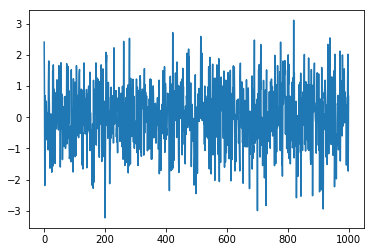

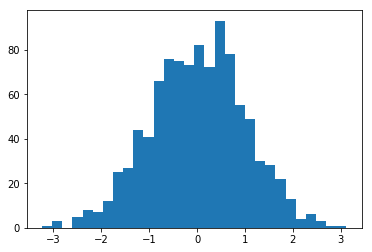

In [4]:
x = np.random.randn(1000)

plt.plot(x)
plt.figure()
plt.hist(x, 30);

`x` is an OU process with $\sigma = 1$ and $\tau = 0$ (memory is lost immediately).

## OU process implementation

*Reference: [Gillespie's explicit update formula](http://10.1103/PhysRevE.54.2084)*

If we know the value `x0` of the process at time $t$,
we can compute the value at time $t + \delta t$ **in one step**:


In [5]:
x0 = 1    # value of the process at time t
N_norm = np.random.randn()  # a Normal random number

# Gillespie's explicit update formula:
relax = np.exp(-δt / τ)
diffuse = σ * np.sqrt(1 - relax**2)
x1 = x0 * relax + diffuse * N_norm
x1

-0.23676394605468376

In [6]:
def OU_update0(*, x_prev, δt, τ, σ):
    '''Compute the OU process at point δt after it was in x0
    
    Knowing the value `x_prev` of an OU process at time "t",
    this function return the value at time "t + δt".
    
    Arguments:
        x_prev (float): value of the process at time "t"
        δt (float): time increment after which to evaluate the OU process
        τ (float): relaxation time, i.e. time after which correlation is lost
        σ (float): standard deviation each point of the OU process
        
    Returns:
        The value of the OU process after a time `δt`. from the time
        it was 
    '''
    N_norm = np.random.randn()
    relax = np.exp(-δt / τ)
    diffuse = σ * np.sqrt(1 - relax**2)
    return x_prev * relax + diffuse * N_norm


def OU_process0(num_steps, *, δt=0.1, x0=0, τ=1, σ=2, OU_update=OU_update0):
    '''Compute the `num_step` of an OU process.
    
    Arguments:
        δt (float): time increment after which to evaluate the OU process
        x0 (float): initital value of the OU process
        τ (float): relaxation time, i.e. time after which correlation is lost
        σ (float): standard deviation each point of the OU process
    
    Returns:
        Array of size `num_steps + 1` simulating an OU process.
    '''
    x = [x0]
    for _ in range(num_steps):
        x.append(OU_update0(x_prev=x[-1], δt=δt, σ=σ, τ=τ)) 
    return x

In [7]:
OU_update0(x_prev=1, δt=0.1, τ=τ, σ=σ)

1.1284269640077205

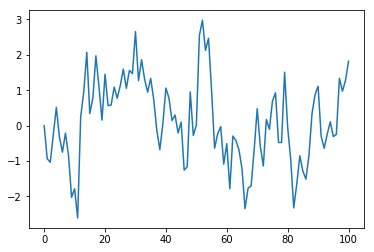

In [8]:
# OU process parameters
τ = 1
σ = 2

# Simulation parameters
num_steps = 100
δt = 0.1
x0 = 1

# OU Simulation
x = OU_process0(num_steps, δt=δt, σ=σ, τ=τ)

plt.plot(x);

**Note:**

In [9]:
len(x) == num_steps + 1

True

because we simulate `num_steps` points, plus `x0` taken as first element.

## Playing with the OU process

OU process is a "mean reverting" process, it means:

> we can start form any point it will always go back around 0


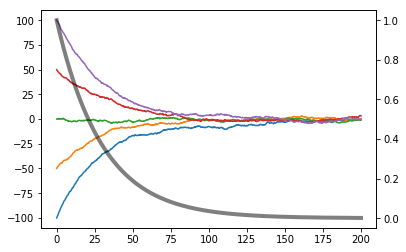

In [10]:
params = dict(num_steps=1000, δt=0.2, τ=30, σ=2)
t = np.arange(params['num_steps'] + 1) * params['δt']
for x0 in range(-100, 101, 50):
    x = OU_process0(x0=x0, **params)
    plt.plot(t, x)

plt.twinx()
plt.plot(t, np.exp(-t / params['τ']), color='k', alpha=0.5, lw=4)

> **NOTE:** play with `τ` to see how the process changes

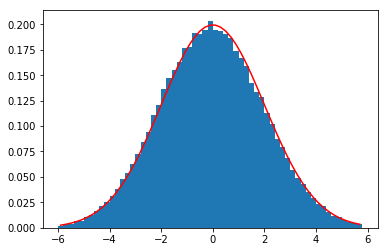

In [11]:
# Histogram of OU process values
x = OU_process0(num_steps=100000, σ=σ)
bins = np.arange(-3 * σ, 3 * σ, 0.2)
bins_centers = bins[:-1] + 0.5 * (bins[1] - bins[0])
plt.hist(x, bins=bins, density=True);

# "Analytical" Gaussian distribution (red line)
plt.plot(bins_centers, norm.pdf(bins_centers, 0, σ), '-r');

> **NOTE**: Model and experiment agree!

**TIP 1**: Always test before optimize!

## Test 1: Normality

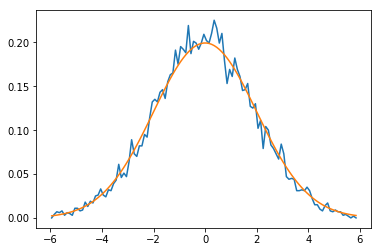

In [12]:
σ = 2
num_steps = 10000

x = OU_process0(num_steps, σ=σ)

# Test 1: Normality
bins = np.arange(-3 * σ, 3 * σ, 0.1)
bins_centers = bins[1:] - 0.5 * (bins[1] - bins[0])

y_experim, _ = np.histogram(x, bins=bins, density=True)
y_model = norm.pdf(bins_centers, 0, σ)

score = ((y_experim - y_model)**2).sum()
assert score < 0.02, f'{score}'

plt.plot(bins_centers, y_experim)
plt.plot(bins_centers, y_model);

## Test 2: Correlation

Text(0.5,0,'Time lags')

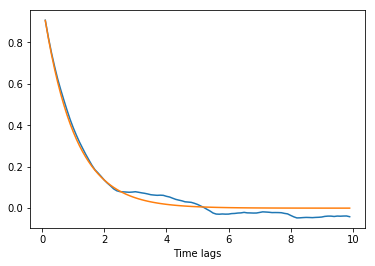

In [13]:
num_steps = 10000
τ = 1
δt = 0.1

# OU simulation
x = OU_process0(num_steps, δt=δt, τ=τ)

# Test correlation
xc = np.arange(1, int(10 * τ / δt)) * δt
corr = [np.corrcoef(x[i:], x[:-i])[0, 1] for i in range(1, len(xc) + 1)]

plt.figure()
plt.plot(xc, corr, label='Correlation coefficient')
plt.plot(xc, np.exp(-xc/τ), label='Exponential function');
plt.xlabel('Time lags')

## Test 3: initial value

In [14]:
num_steps = 3
for x0 in range(10):
    x = OU_process0(num_steps, x0=x0)
    assert x0 == x[0]

# Benchmarks

> **Magic commands:** IPython has special [magic commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html) 
> that cannot be used in plain python.
>
> Magics start with:
> - `%` for commands working on a one-line of code (can be anywhere in a cell)
> - `%%` cell-level magics operate on all the lines in a cell and must be in the first line

In [15]:
num_steps = int(1e6)

## %timeit magic

In [16]:
%timeit -n1 OU_process0(num_steps)

4.97 s ± 217 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Cool, we have a way to measure the execution time, but where the time is spent?

## %prun magic


In [17]:
%prun OU_process0(num_steps)

`%prun` uses [Python's profiler](https://docs.python.org/3.6/library/profile.html)
to find which function "eats" the most time.

**Legend:**

- `ncalls`: number of calls.
- `tottime`: total time spent in the given function (and excluding time made in calls to sub-functions)
- `percall`: is the quotient of `tottime / ncalls`
- `cumtime`: is the cumulative time spent in this and all subfunctions (from invocation till exit).     
  This figure is accurate even for recursive functions.

### Observations

- Total execution time is 5.6 secs
- Cumulative time in `OU_update0`: 4.9 secs (total), 4.1 (excluding sub-function calls)
- The for-loop in `OU_process0` is negligible at this point

## Line profiling

In [18]:
%load_ext line_profiler

Run `OU_process0(num_steps)` while profiling the function `OU_update0` line-by-line:

In [19]:
%lprun -f OU_update0 OU_process0(num_steps)

**Legend:**

- `Hits`: number of times line is executed
- `Time`: total time spent executing the line
- `Per Hit`: time spent executing the line once
- `% Time`: percentage of time spent executing the line

### Observations

- Most time is spent in algebraic computations
- Random number generation takes 20% of the time

# Optimizations

> **TIP:** Focus on the bottleneck, stop when performances are acceptable.

> **TIP:**  Try not to compromise clarity for speed.

In [20]:
np.random.seed(1)
x_ref = OU_process0(num_steps)

## Use math instead of numpy

We only doing scalar computations so we can replace `numpy` with `math` from the standard library:

In [21]:
import math

def OU_update1(*, x_prev, δt, τ, σ):
    N_norm = np.random.randn()
    relax = math.exp(-δt / τ)
    diffuse = σ * math.sqrt(1 - relax**2)
    return x_prev * relax + diffuse * N_norm

In [22]:
np.random.seed(1)
x = OU_process0(num_steps, OU_update=OU_update1)
assert np.allclose(x, x_ref)

In [23]:
%timeit -n1 -r1 OU_process0(num_steps, OU_update=OU_update1)

5.13 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [24]:
%lprun -f OU_update1 OU_process0(num_steps, OU_update=OU_update1)

### Results 

- We get a 4x improvement!
- Now random number generation takes ~40% of time, becoming a bottleneck!

## Move RNG out of the loop

In [25]:
def OU_update2(*, x_prev, δt, τ, σ, N_norm):
    relax = math.exp(-δt / τ)
    diffuse = σ * math.sqrt(1 - relax**2)
    return x_prev * relax + diffuse * N_norm

def OU_process1(num_steps, *, δt=0.1, x0=0, τ=1, σ=2, OU_update=OU_update2):
    N_norm = np.random.randn(num_steps)
    x = [x0]
    for i in range(num_steps):
        x.append(OU_update(x_prev=x[-1], δt=δt, σ=σ, τ=τ, N_norm=N_norm[i])) 
    return x

In [26]:
np.random.seed(1)
x = OU_process1(num_steps, OU_update=OU_update2)
assert np.allclose(x, x_ref)

In [27]:
%timeit -n1 -r1 OU_process1(num_steps, OU_update=OU_update2)

1.26 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [28]:
%prun OU_process1(num_steps, OU_update=OU_update2)

In [29]:
%lprun -f OU_update2 OU_process1(num_steps, OU_update=OU_update2)

### Results

- 40% improvements, RNG is now negligible
- next step is improving the algebraic computations

## Streamline the loop

- We compute `relax` and `diffuse` only once
- We get rid of the inner function

In [30]:
def OU_process2(num_steps, *, δt=0.1, x0=0, τ=1, σ=2):
    N_norm = memoryview(np.random.randn(num_steps))
    
    relax = math.exp(-δt / τ)
    diffuse = σ * math.sqrt(1 - relax**2)

    x = [x0]
    for i in range(num_steps):
        x.append(
            x[-1] * relax + diffuse * N_norm[i]
        ) 
    return x

In [31]:
np.random.seed(1)
x = OU_process2(num_steps)
assert np.allclose(x, x_ref)

In [32]:
np.random.seed(1)
%timeit -n1 -r1 OU_process2(num_steps)

337 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [33]:
%prun OU_process2(num_steps)

In [34]:
np.random.seed(1)
%lprun -f OU_process2 OU_process2(num_steps)

### Results

- 2x improvement
- now most time in:
    1. for-loop + list append
    2. scalar computations

### Lessons

- numpy array element access is slow when using a scalar index
- speed can be improved using a `memoryview` (still pure python!)

## More numpy

- Preallocate output as numpy's array instead of appending to a list

In [35]:
def OU_process3(num_steps, *, δt=0.1, x0=0, τ=1, σ=2):
    N_norm = memoryview(np.random.randn(num_steps))
    
    relax = math.exp(-δt / τ)
    diffuse = σ * math.sqrt(1 - relax**2)

    x = memoryview(np.empty(num_steps + 1))
    x[0] = x0
    for i in range(num_steps):
        x[i+1] = x[i] * relax + diffuse * N_norm[i]
    return x

In [36]:
np.random.seed(1)
x = OU_process3(num_steps)
assert np.allclose(x, x_ref)

In [37]:
np.random.seed(1)
%timeit -n1 -r1 OU_process3(num_steps)

289 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [38]:
np.random.seed(1)
%lprun -f OU_process3 OU_process3(num_steps)

### Results

- ~10% improvement
- we cannot further vectorize because the relation is recurrent (ARMA)

### Lessons

- appending to a list is relatively fast (not a bottleneck here)


## Numba

In [39]:
import numba

In [40]:
OU_process_nb = numba.jit(OU_process3)

The code below is "disabled" to avoid error:

```python
np.random.seed(1)
x = OU_process_nb(num_steps, δt=0.1, x0=0, τ=1, σ=2)
assert np.allclose(x, x_ref)
```

```
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
TypeError: cannot convert native memoryview(float64, 1d, C) to Python object

The above exception was the direct cause of the following exception:

SystemError                               Traceback (most recent call last)
<ipython-input-107-f2ff2af6f7a9> in <module>()
      1 np.random.seed(1)
----> 2 x = OU_process_nb(num_steps, δt=0.1, x0=0, τ=1, σ=2)
      3 assert np.allclose(x, x_ref)

SystemError: LiftedLoop(<function OU_process3 at 0x1a1f049d90>) returned a result with an error set
```

Ops! Looks like `memoryviews` confuse numba here, let's try without them:

In [41]:
@numba.jit
def OU_process_nb(num_steps, *, N_norm, δt=0.1, x0=0., τ=1., σ=2.):
    relax = math.exp(-δt / τ)
    diffuse = σ * math.sqrt(1 - relax**2)

    x = np.empty(num_steps + 1)
    x[0] = x0
    for i in range(num_steps):
        x[i+1] = x[i] * relax + diffuse * N_norm[i]
    return x

While we are at it, we also decouple the RNG form the simulation, by passing already generated random numbers.

### Test (numba)

In [42]:
np.random.seed(1)
N_norm = np.random.randn(num_steps)
x = OU_process_nb(num_steps, N_norm=N_norm, δt=0.1, x0=0, τ=1, σ=2)
assert np.allclose(x, x_ref)

### Benchmark (numba)

- We fix the seed for more accurate benchmarks
- We time the whole simulation (RNG + OU_process)

In [43]:
%%timeit -n1 -r1
np.random.seed(1)
N_norm = np.random.randn(num_steps)
x = OU_process_nb(num_steps, N_norm=N_norm, δt=0.1, x0=0, τ=1, σ=2)

46.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Results

- An additional 7.5x improvement. Good!

## Cython


In [44]:
%load_ext cython

### Implementations (cython)

**Cython Version 0** - We start compiling the code with no optimizations (slow):

In [45]:
%%cython -a

import numpy as np
cimport numpy as np
from libc.math cimport exp, sqrt

def OU_process_cy0(num_steps, *, N_norm, dt=0.1, x0=0, tau=1, sigma=2):
    relax = exp(-dt / tau)
    diffuse = sigma * sqrt(1 - relax**2)

    x = np.empty(num_steps + 1)
    x[0] = x0
    for i in range(num_steps):
        x[i+1] = x[i] * relax + diffuse * N_norm[i]
    return x

**Cython Version 1** - We add type declaration *only the important variables* (arrays and loop variables):

In [46]:
%%cython -a

import numpy as np
cimport numpy as np
from libc.math cimport exp, sqrt

def OU_process_cy1(int num_steps, *, double[:] N_norm, dt=0.1, 
                x0=0, tau=1, sigma=2):
    cdef Py_ssize_t i
    cdef double relax, diffuse
    cdef double[:] x = np.empty(num_steps + 1)
    
    relax = exp(-dt / tau)
    diffuse = sigma * sqrt(1 - relax**2)

    x[0] = x0
    for i in range(num_steps):
        x[i+1] = x[i] * relax + diffuse * N_norm[i]
    return np.asfarray(x)

**Cython Version 2** - Add type declarations for all variables and remove safety checks (dangerous):

In [47]:
%%cython -a

import cython
import numpy as np
cimport numpy as np
from libc.math cimport exp, sqrt

@cython.boundscheck(False)
@cython.cdivision(True)
@cython.wraparound(False)
def OU_process_cy2(int num_steps, *, double[:] N_norm, double dt=0.1, 
                   double x0=0, double tau=1, double sigma=2):
    cdef Py_ssize_t i
    cdef double relax, diffuse
    cdef double[:] x = np.empty(num_steps + 1)
    
    relax = exp(-dt / tau)
    diffuse = sigma * sqrt(1 - relax**2)

    x[0] = x0
    for i in range(num_steps):
        x[i+1] = x[i] * relax + diffuse * N_norm[i]
    return np.asfarray(x)

### Test (cython)

- Test the 3 cython versions against the reference implementation:

In [48]:
np.random.seed(1)
N_norm = np.random.randn(num_steps)
x = OU_process_cy0(num_steps, N_norm=N_norm, dt=0.1, x0=0, tau=1, sigma=2)
assert np.allclose(x, x_ref)

In [49]:
np.random.seed(1)
N_norm = np.random.randn(num_steps)
x = OU_process_cy1(num_steps, N_norm=N_norm, dt=0.1, x0=0, tau=1, sigma=2)
assert np.allclose(x, x_ref)

In [50]:
np.random.seed(1)
N_norm = np.random.randn(num_steps)
x = OU_process_cy2(num_steps, N_norm=N_norm, dt=0.1, x0=0, tau=1, sigma=2)
assert np.allclose(x, x_ref)

> **Success**: cython versions give the same results as the reference!

### Benchmarks (cython)

- We fix the seed for more accurate benchmarks
- We time the whole simulation (RNG + OU_process)

In [51]:
%%timeit
np.random.seed(1)
N_norm = np.random.randn(num_steps)
x = OU_process_cy0(num_steps, N_norm=N_norm, dt=0.1, x0=0, tau=1, sigma=2)

545 ms ± 15.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
%%timeit
np.random.seed(1)
N_norm = np.random.randn(num_steps)
x = OU_process_cy1(num_steps, N_norm=N_norm, dt=0.1, x0=0, tau=1, sigma=2)

39.1 ms ± 1.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [53]:
%%timeit
np.random.seed(1)
N_norm = np.random.randn(num_steps)
x = OU_process_cy2(num_steps, N_norm=N_norm, dt=0.1, x0=0, tau=1, sigma=2)

38.9 ms ± 2.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


> **Success**: performance similar to Numba

### Cython Type References

#### Numpy's types

After `cimport numpy as np` use numpy's types appending `_t`. Examples: 

- `np.int8_t`, `np.int16_t`, `np.int32_t`, `np.int64_t`,
- `np.uint8_t`, `np.uint16_t`, `np.uint32_t`, `np.uint64_t`,
- `np.float16_t`, `np.float32_t`, `np.float_64`

#### double

`double` is equivalent to `np.float_64`, but does not require numpy.

#### Index type

For variables used as index, cython suggests using `Py_ssize_t` instead of other integer types for best performances.



### On a closer look ....

In [54]:
%%timeit -n1 -r1 
N_norm = np.random.randn(num_steps)

35 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


> Most of the time is now spent in generating random numbers!!!

Let's benchmark only the OU_process part:

In [55]:
np.random.seed(1)
num_steps = int(1e6)
N_norm = np.random.randn(num_steps)

**Cython Version 0**, no type declarations:

In [56]:
%%timeit
x = OU_process_cy0(num_steps, N_norm=N_norm, dt=0.1, x0=0, tau=1, sigma=2)

542 ms ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Cython Version 1**, with variable declarations:

In [57]:
%%timeit
x = OU_process_cy1(num_steps, N_norm=N_norm, dt=0.1, x0=0, tau=1, sigma=2)

6.54 ms ± 182 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Cython Version 2**, no safety checks (dangerous):

In [58]:
%%timeit
x = OU_process_cy2(num_steps, N_norm=N_norm, dt=0.1, x0=0, tau=1, sigma=2)

6.54 ms ± 95.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Numba Version**:

In [59]:
%%timeit 
x = OU_process_nb(num_steps, N_norm=N_norm, δt=0.1, x0=0, τ=1, σ=2)

4.92 ms ± 776 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Lessons

- Cython does not accept UTF-8 identifiers
- the `-a` flags helps finding "hot-spots" in cython code
- Numba and cython reach the same C-like speeds (Numba is slightly faster in this case)
- Removing bounds checks, negative index wraparound and C-division
  does not make a big difference in performance but make the code 
  more brittle, risking to crash the interpreter if there is a bug. **Not worth it!**

### Ranom number generation

- We are already using a single vectorized numpy call

- Can we do better?

## Faster Random Numbers

Numpy uses:

- MT19937 for generating uniform random numbers in 0..1
- Box-Muller method for converting uniform random numbers to normal

Both are suboptimal:

- There are RNG with higher speed, better statistical properties and jump-ahead features
- Zigurat transformation is superior to Box-Muller in terms of speed and accuracy

### randomgen: future of numpy

[randomgen](https://github.com/bashtage/randomgen) is a numpy-compatible package 
aiming to replace the current numpy implementation.
It provides many RNG engines that are superior to MT19937. 
randomgen also implements the Ziguratt method for normals.

Even if not in numpy yet, it can be used today with `pip install randomgen`.

In [60]:
from randomgen import RandomGenerator, Xoroshiro128

In [61]:
%%timeit
np.random.randn(int(1e7))

335 ms ± 21.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [62]:
rg = RandomGenerator(Xoroshiro128())

In [63]:
%%timeit
rg.randn(int(1e7))

133 ms ± 4.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


> About 2-3x speed improvement!

> **WARNING**: random numbers are different in the two cases!

- Numpy's `randn` + cython:

In [64]:
%%timeit
N_norm = np.random.randn(num_steps)
x = OU_process_cy1(num_steps, N_norm=N_norm, dt=0.1, x0=0, tau=1, sigma=2)

38.8 ms ± 803 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


- Randomgen's `randn` + cython:

In [65]:
%%timeit
N_norm = rg.randn(num_steps)
x = OU_process_cy1(num_steps, N_norm=N_norm, dt=0.1, x0=0, tau=1, sigma=2)

22.8 ms ± 3.06 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


- Randomgen's `randn` + numba:

In [66]:
%%timeit
N_norm = rg.randn(num_steps)
x = OU_process_nb(num_steps, N_norm=N_norm, δt=0.1, x0=0, τ=1, σ=2)

17.1 ms ± 713 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


> Overall >2x speed improvement in the simulation. Not bad!

## Final score

In [67]:
5.8 / 0.016

362.5

The latest version using `randomgen` and `numba` achieves 
~350x speed improvement compared to the first naive version!

## Profiling cython code

*See [Python Line_profiler and Cython function](https://stackoverflow.com/questions/24144931/python-line-profiler-and-cython-function)*


We have max performances for RNG, can we go back to optimize the cython more
with line_profiler?

In [68]:
from Cython.Compiler import Options
Options.linetrace = True
Options.binding = True
Options.docstrings = True

In [69]:
%%cython -f --compile-args=-DCYTHON_TRACE=1

import numpy as np
cimport numpy as np
from libc.math cimport exp, sqrt

def OU_process_cy1_lp(int num_steps, *, double[:] N_norm, dt=0.1, x0=0, tau=1, sigma=2):
    cdef Py_ssize_t i
    cdef double relax, diffuse
    cdef double[:] x = np.empty(num_steps + 1)
    
    relax = exp(-dt / tau)
    diffuse = sigma * sqrt(1 - relax**2)

    x[0] = x0
    for i in range(num_steps):
        x[i+1] = x[i] * relax + diffuse * N_norm[i]
    return x

In [70]:
%lprun -f OU_process_cy1_lp OU_process_cy1_lp(num_steps, N_norm=N_norm, dt=0.1, x0=0, tau=1, sigma=2)

/Users/anto/miniconda3/envs/py36_optimize/lib/python3.6/site-packages/line_profiler.py:321: UserWarning: Could not extract a code object for the object <built-in function OU_process_cy1_lp>
  profile = LineProfiler(*funcs)


> 😢 Either I did something wrong or is currently not working https://github.com/rkern/line_profiler/issues/94

Actually, I found that `line_profiler` works with cython when moved out of the notebook. See below.

# Packaging Cython

*References:*
- [Cython for NumPy users](http://docs.cython.org/en/latest/src/userguide/numpy_tutorial.html)

After the implementation is optimized we want to move it to a stand-alone module for easier distribution and testing.

**Step 1** Move the cython code to a `.pyx` file:

In [71]:
!cat ou_process.pyx

import numpy as np
cimport numpy as np
from libc.math cimport exp, sqrt

def OU_process_cy(int num_steps, *, double[:] N_norm, dt=0.1,
                x0=0, tau=1, sigma=2):
    cdef Py_ssize_t i
    cdef double relax, diffuse
    cdef double[:] x = np.empty(num_steps + 1)
    relax = exp(-dt / tau)
    diffuse = sigma * sqrt(1 - relax**2)

    x[0] = x0
    for i in range(num_steps):
        x[i+1] = x[i] * relax + diffuse * N_norm[i]
    return x


**Setp 2** Create a `setup.py` (here I added provisions for profiling):

In [72]:
!cat setup.py

# To build the cython extensions use:
# python setup.py build_ext --inplace
#

from distutils.core import setup
from distutils.extension import Extension
from Cython.Build import cythonize
import numpy as np

extensions = [
    Extension(
        'ou_process',
        ['ou_process.pyx'],
        include_dirs=[np.get_include()],
        # Uncomment the following line for profiling
        define_macros=[('CYTHON_TRACE', '1')],
    )
]

setup(
    name="Cyton functions to simulate an OU process",
    ext_modules=cythonize(
        extensions,
        # Uncomment the following line for profiling
        compiler_directives={'linetrace': True, 'binding': True},
    ),
)


**Step 3** Compile the cython module:

In [73]:
!python setup.py build_ext --inplace

running build_ext


**Step 4**: import, test, benchmark

In [74]:
from ou_process import OU_process_cy

In [75]:
np.random.seed(1)
N_norm = np.random.randn(num_steps)
x = OU_process_cy(num_steps, N_norm=N_norm, dt=0.1, x0=0, tau=1, sigma=2)
assert np.allclose(x, x_ref)

In [76]:
%%timeit
x = OU_process_cy(num_steps, N_norm=N_norm, dt=0.1, x0=0, tau=1, sigma=2)

6.9 ms ± 390 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Test passed! 🎉🎉🎉

## Reloading cython code

In case of modifications, you need to recompile the code and restart the kernel. 

`pyximport` has some limited support for reloading, you may want to check it out
[Compiling with pyximport](https://cython.readthedocs.io/en/latest/src/userguide/source_files_and_compilation.html#compiling-with-pyximport).

> Another good reason for developing in the notebook using the `%%cython` magic.

## Line profiling (try2)

Let's try again line_profiler on the cython function we moved to a file:

In [77]:
%lprun -f OU_process_cy OU_process_cy(num_steps, N_norm=N_norm, dt=0.1, x0=0, tau=1, sigma=2)

> Works this time!

### Line_profiler output
```

Total time: 0.325194 s
File: ou_process.pyx
Function: OU_process_cy at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     5                                           def OU_process_cy(int num_steps, *, double[:] N_norm, dt=0.1,
     6                                                           x0=0, tau=1, sigma=2):
     7                                               cdef Py_ssize_t i
     8                                               cdef double relax, diffuse
     9         1        691.0    691.0      0.2      cdef double[:] x = np.empty(num_steps + 1)
    10                                           
    11         1          3.0      3.0      0.0      relax = exp(-dt / tau)
    12         1          1.0      1.0      0.0      diffuse = sigma * sqrt(1 - relax**2)
    13                                           
    14         1          1.0      1.0      0.0      x[0] = x0
    15         1          1.0      1.0      0.0      for i in range(num_steps):
    16   1000000     324449.0      0.3     99.8          x[i+1] = x[i] * relax + diffuse * N_norm[i]
    17         1         48.0     48.0      0.0      return x
```

### Results
- 99% of time is spent on the line:
      x[i+1] = x[i] * relax + diffuse * N_norm[i]

# Parallelization

See notebook [Parallelism with Joblib](Parallelism%20with%20Joblib.ipynb).